# Preprocessing Dataset

In [14]:
import pandas as pd
from sklearn.impute import KNNImputer

samples = pd.read_csv('wines.csv')

samples['type'] = samples['type'].replace({'white': 0, 'red': 1}).astype(int)
samples[:] = KNNImputer(n_neighbors=25, weights='distance').fit_transform(samples)

samples['other sulfur dioxide'] = samples['total sulfur dioxide'] - samples['free sulfur dioxide']

targets = samples['quality']
samples.drop(columns=['quality', 'total sulfur dioxide'], inplace=True)

white_sample_ids = samples['type'] == 0.0
red_samples_ids = samples['type'] == 1.0
samples

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol,other sulfur dioxide
0,0.0,7.0,0.270,0.36,20.7,0.045,45.0,1.00100,3.00,0.450000,8.8,125.0
1,0.0,6.3,0.300,0.34,1.6,0.049,14.0,0.99400,3.30,0.490000,9.5,118.0
2,0.0,8.1,0.280,0.40,6.9,0.050,30.0,0.99510,3.26,0.440000,10.1,67.0
3,0.0,7.2,0.230,0.32,8.5,0.058,47.0,0.99560,3.19,0.400000,9.9,139.0
4,0.0,7.2,0.230,0.32,8.5,0.058,47.0,0.99560,3.19,0.400000,9.9,139.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,1.0,6.2,0.600,0.08,2.0,0.090,32.0,0.99490,3.45,0.580000,10.5,12.0
6493,1.0,5.9,0.550,0.10,2.2,0.062,39.0,0.99512,3.52,0.764722,11.2,12.0
6494,1.0,6.3,0.510,0.13,2.3,0.076,29.0,0.99574,3.42,0.750000,11.0,11.0
6495,1.0,5.9,0.645,0.12,2.0,0.075,32.0,0.99547,3.57,0.710000,10.2,12.0


# Evaluating Regression Model

In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

random_state = 0
x_train, x_test, y_train, y_test = train_test_split(samples, targets, random_state=0, test_size=0.1)

model = XGBRegressor(random_state=random_state, n_jobs=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

f'XGBOOST MAE = {mean_absolute_error(y_test, y_pred)}'

'XGBOOST MAE = 0.43958222462580754'

# Feature Importance with SHAP

In [16]:
import shap

model = XGBRegressor(random_state=random_state, n_jobs=-1)
model.fit(samples, targets)

explainer = shap.Explainer(model, seed=random_state)
shap_values = explainer(samples)
shap_values.shape

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(6497, 12)

# Visualizing Model Explanation of a Random White Samples

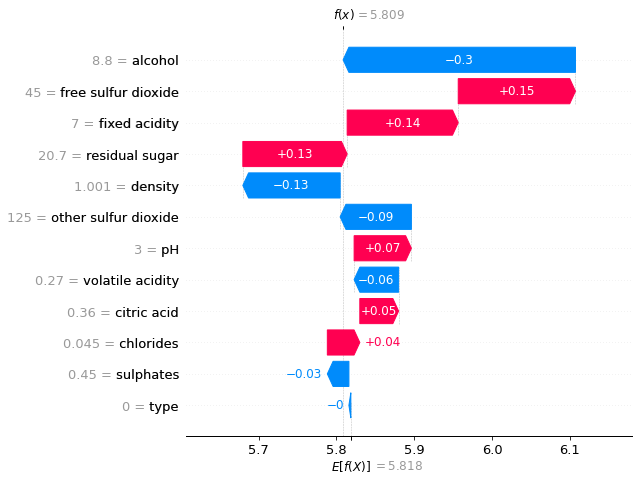

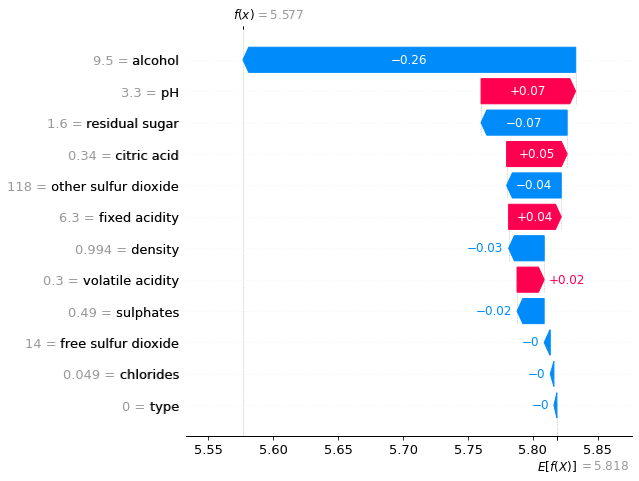

In [23]:
import numpy as np

white_sample_id = np.where(white_sample_ids)[0][0]
white_sample_id2 = np.where(white_sample_ids)[0][1]

shap.plots.waterfall(shap_values[white_sample_id], max_display=samples.shape[1])
shap.plots.waterfall(shap_values[white_sample_id2], max_display=samples.shape[1])

Obviously, the most important feature of white wine is `alcohol`. Low alcohol concentrations push the
quality score downwards.Another important feature is residual sugar, which increases the quality
of a wine when having high values and drops the quality score when having lower values.

# Visualizing Model Explanation of a Random Red Samples

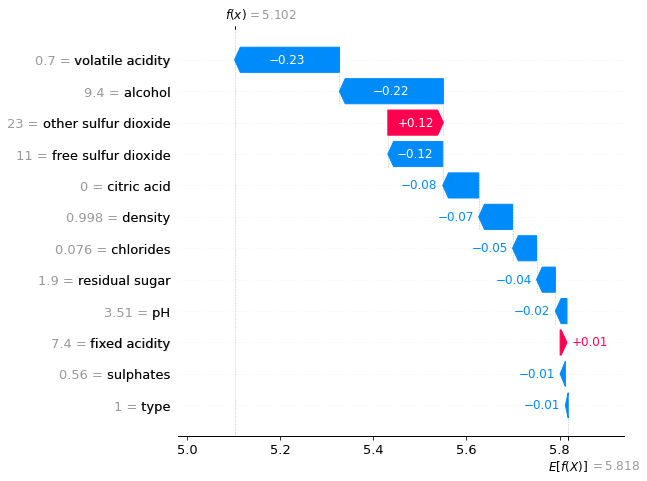

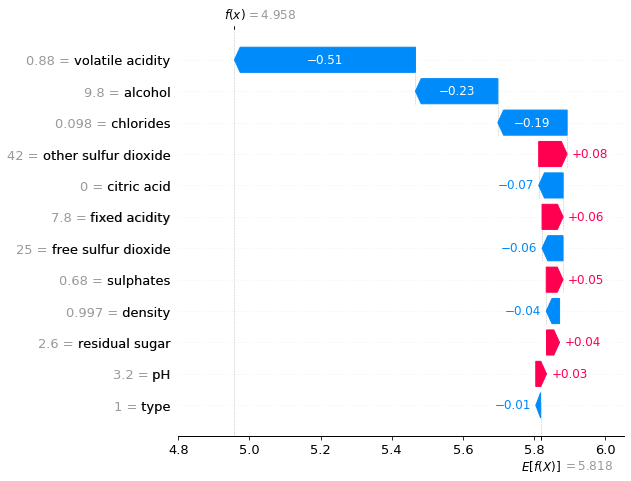

In [28]:
import numpy as np

red_sample_id = np.where(red_samples_ids)[0][0]
red_sample_id2 = np.where(red_samples_ids)[0][1]

shap.plots.waterfall(shap_values[red_sample_id], max_display=samples.shape[1])
shap.plots.waterfall(shap_values[red_sample_id2], max_display=samples.shape[1])

In red wine, more importance is given on volatile acidity, rather than alcohol. Another important features
are alcohol, chlorides and sulfur.

Before analyzing the importance of each feature, it is importance to notice that the
**Red & White wine samples are 2 different types of wine and should be plotted independently**.
This can also be verified by the different importance of the features that the `explainer`
assigns to each type.


# Force Plot of White Sample

In [27]:
shap.initjs()
shap.plots.force(shap_values[white_sample_id])

# Force Plot of Red Sample

In [29]:
shap.plots.force(shap_values[red_sample_id])

Force plots are great plots for visualizing the importance of each feature, as well as the direction
of their influence in the overall quality (in other words, the `force` of each feature).

# Force Plot from a Subset of Samples

To better understand the `force` of each feature, we are going to investigate a subset of wine samples.

In [30]:
random_white_ids = np.random.choice(np.where(white_sample_ids)[0], size=(50,), replace=False)
shap.plots.force(shap_values[random_white_ids])

In [31]:
random_red_ids = np.random.choice(np.where(red_samples_ids)[0], size=(50,), replace=False)
shap.plots.force(shap_values[random_red_ids])

# Plotting the Shap Value Distribution for each Feature

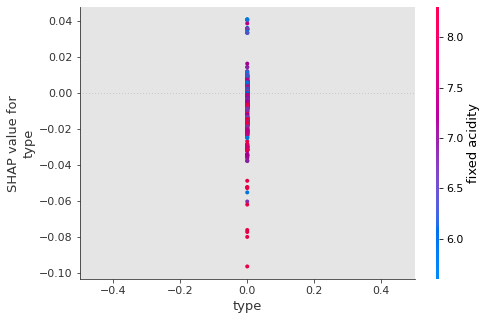

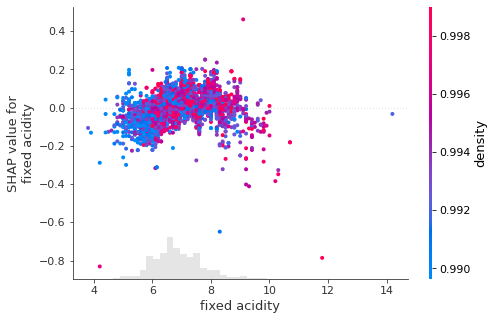

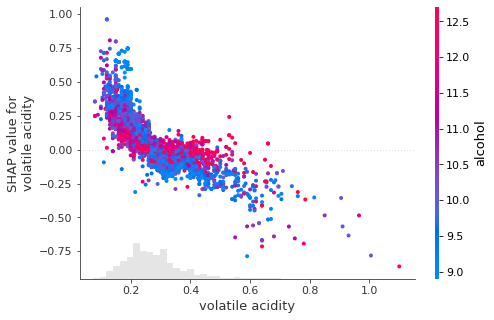

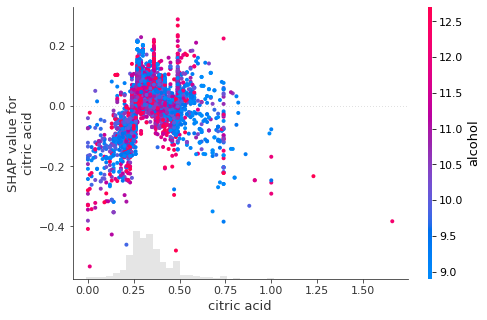

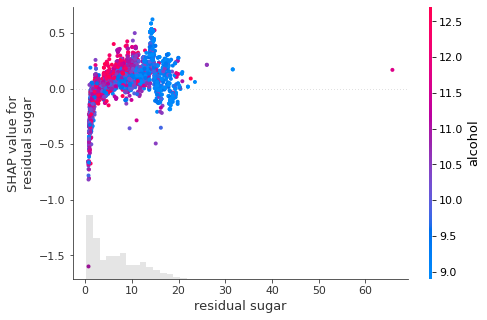

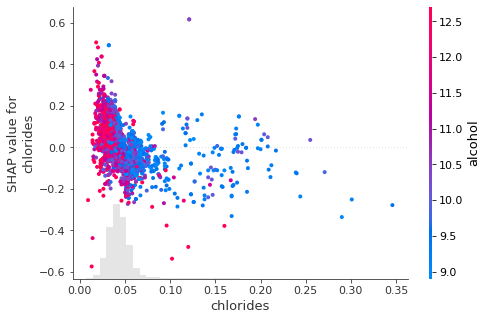

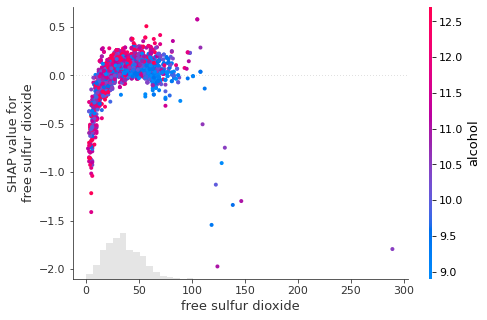

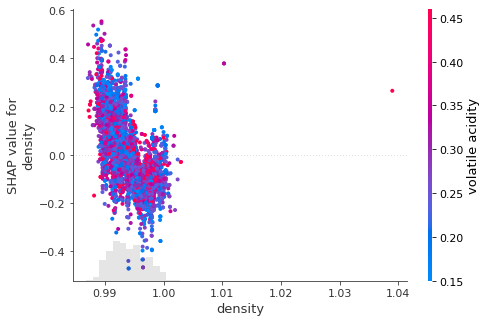

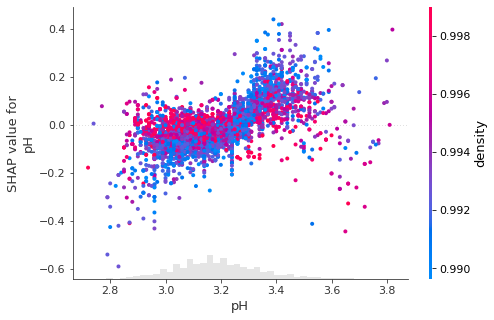

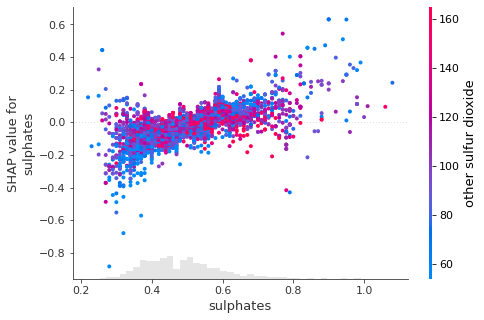

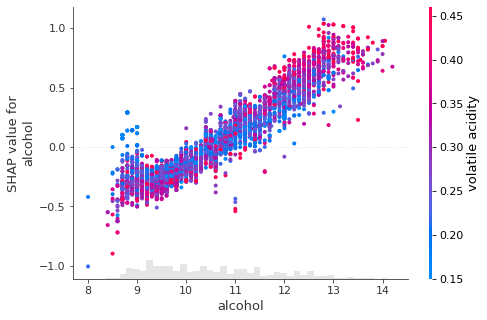

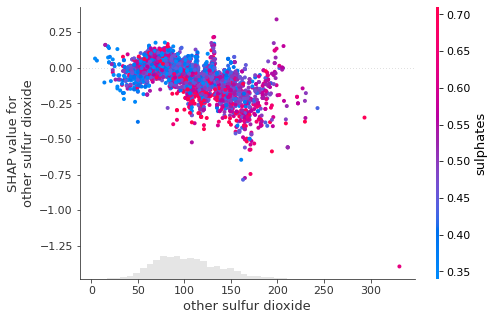

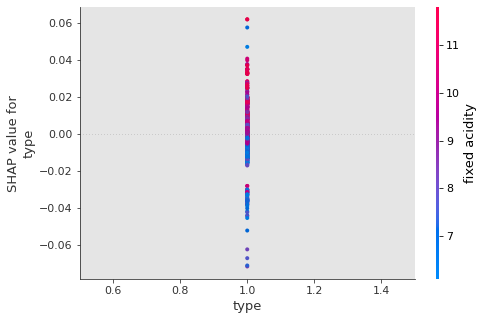

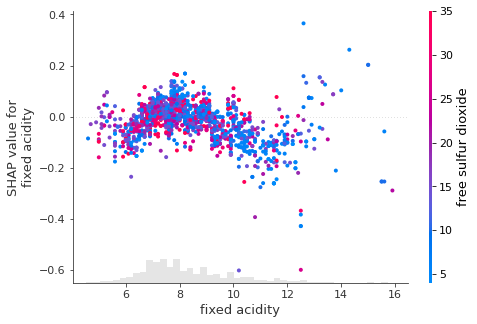

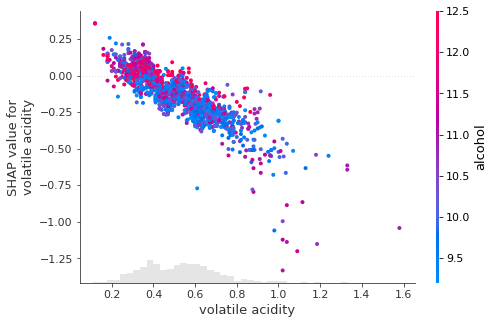

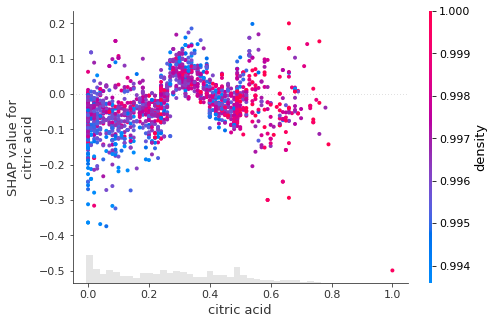

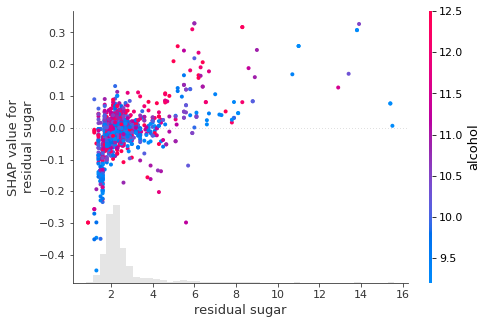

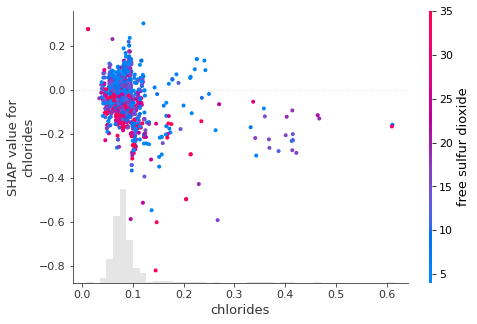

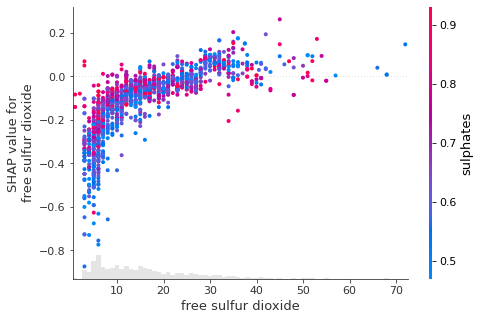

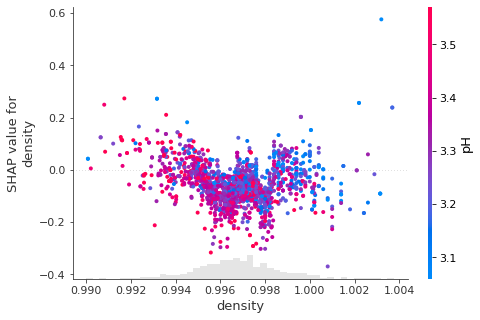

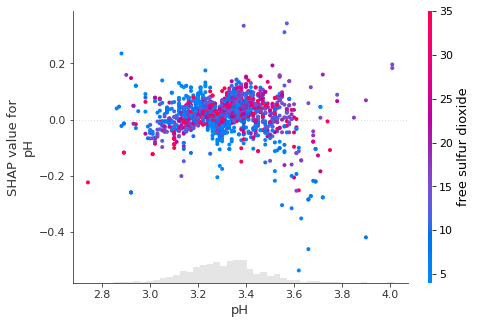

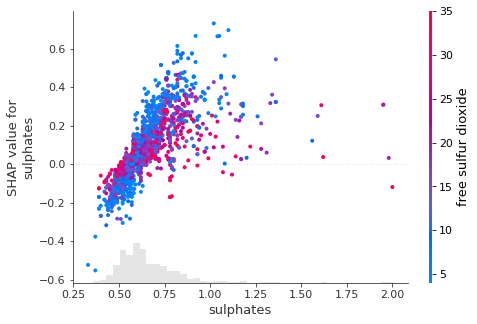

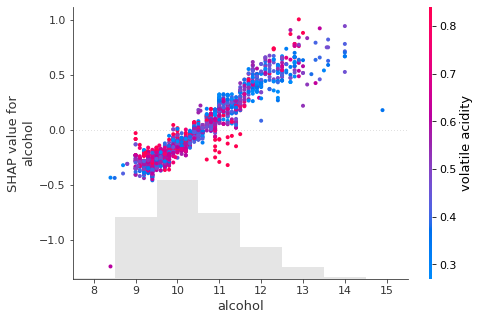

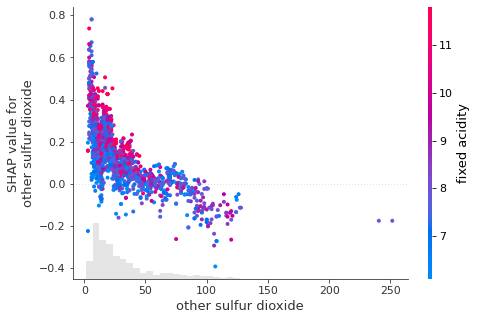

In [38]:
for col in samples.columns:
    white_shap = shap_values[np.where(white_sample_ids)[0]]
    shap.plots.scatter(white_shap[:, col], color=white_shap)

for col in samples.columns:
    red_shap = shap_values[np.where(red_samples_ids)[0]]
    shap.plots.scatter(red_shap[:, col], color=red_shap)

# Other Useful Plots

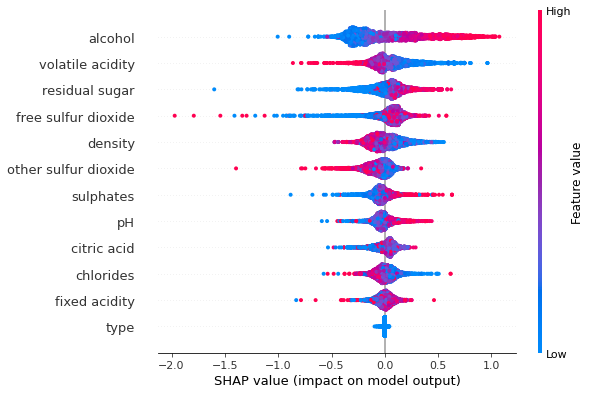

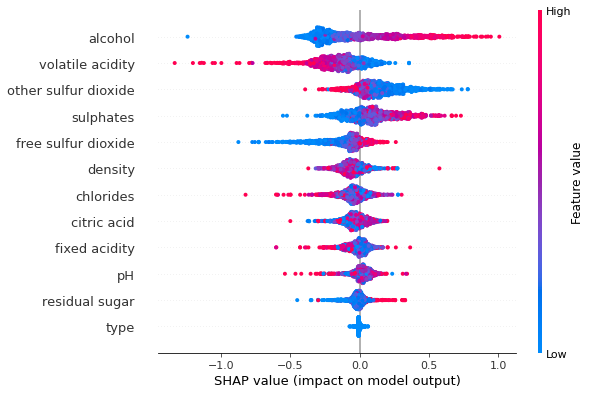

In [42]:
shap.plots.beeswarm(white_shap, max_display=samples.shape[1])
shap.plots.beeswarm(red_shap, max_display=samples.shape[1])

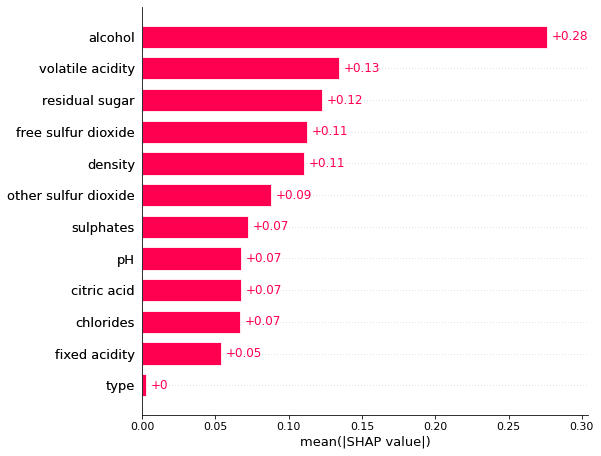

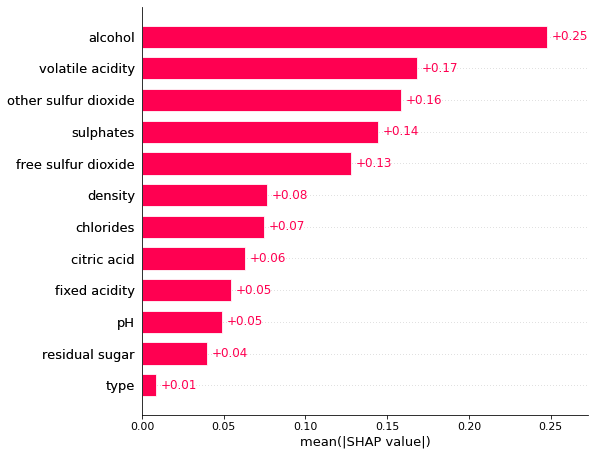

In [41]:
shap.plots.bar(white_shap, max_display=samples.shape[1])
shap.plots.bar(red_shap, max_display=samples.shape[1])